# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter tails.
Valid set: filter tails.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-04 12:09:26.057522


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = True
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = True
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 12:09:56.329204
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 12:09:56.618489
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-04 12:10:17.513552

Training # 1 1
2023-04-04 12:10:17.515601
2023-04-04 12:10:17.515939
Discriminator ZERO -1
Train 1:0 757:668 53.12%
Computed class weights: {0: 1.0666167664670658, 1: 0.9412153236459709}
Valid 1:0 178:150 54.27%
FIT
2023-04-04 12:10:17.582280


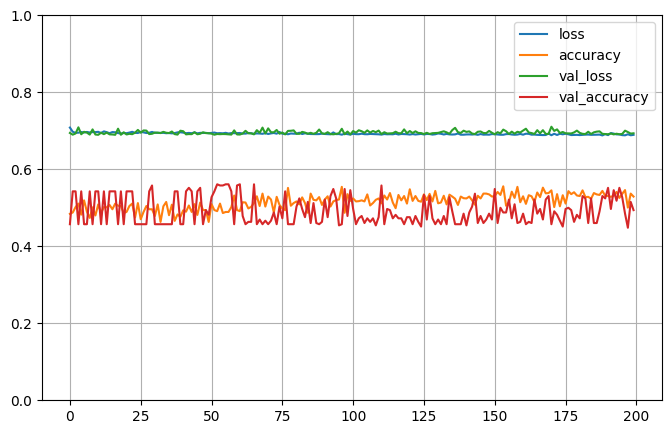


2023-04-04 12:10:49.487940

Testing # 1 1
2023-04-04 12:10:49.488024
2023-04-04 12:10:49.488060
PREDICT
2023-04-04 12:10:49.492005
Test 1:0 178:150 54.27%
Predict 1:0 220:108 67.07%
Test sizes (328, 1025) (328,)
Range of scores: 0.355388 to 0.5558214
Score threshold 0.5
Confusion matrix
 [[ 46 104]
 [ 62 116]]
Normalized matrix
 [[0.1402439  0.31707317]
 [0.18902439 0.35365854]]


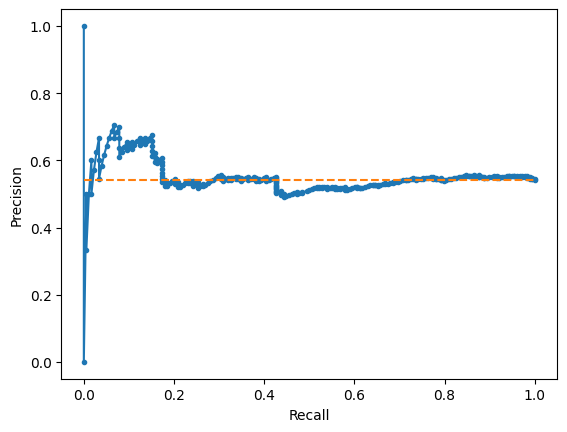

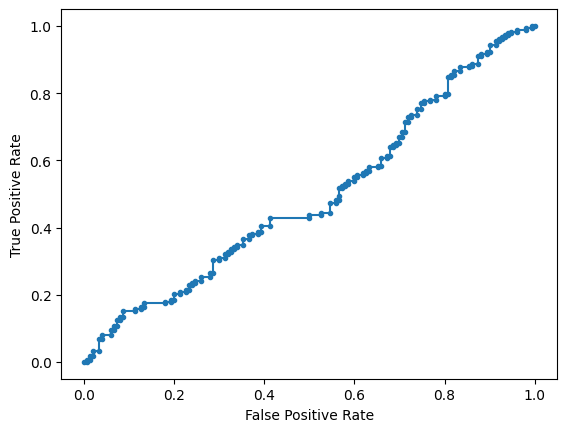

Accuracy: 49.39% Precision: 52.73% Recall: 65.17%
F1: 58.29% MCC: -0.0441
AUPRC: 54.89% AUROC: 49.41%
 accuracy [49.390243902439025]
 precision [52.72727272727272]
 recall [65.1685393258427]
 F1 [58.291457286432156]
 MCC [-0.04414951513898428]
 AUPRC [54.88504785581141]
 AUROC [49.40823970037454]
2023-04-04 12:10:50.515338

Training # 1 2
2023-04-04 12:10:50.515522
2023-04-04 12:10:50.515570
Discriminator ZERO -1
Train 1:0 742:639 53.73%
Computed class weights: {0: 1.0805946791862284, 1: 0.9305929919137467}
Valid 1:0 193:179 51.88%
FIT
2023-04-04 12:10:50.569052


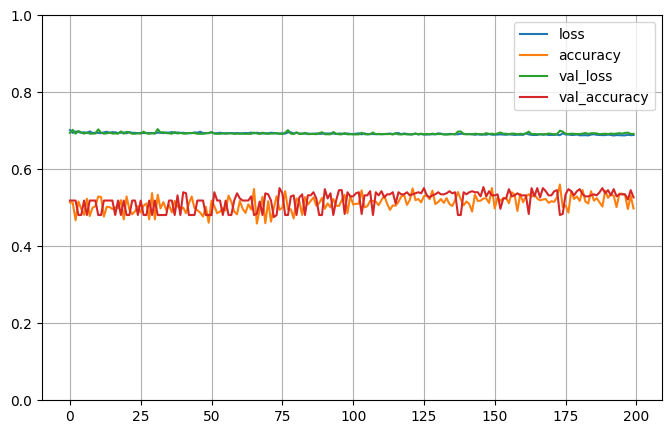


2023-04-04 12:11:22.913340

Testing # 1 2
2023-04-04 12:11:22.913478
2023-04-04 12:11:22.913522
PREDICT
2023-04-04 12:11:22.916517
Test 1:0 193:179 51.88%
Predict 1:0 317:55 85.22%
Test sizes (372, 1025) (372,)
Range of scores: 0.32090074 to 0.5630606
Score threshold 0.5
Confusion matrix
 [[ 29 150]
 [ 26 167]]
Normalized matrix
 [[0.07795699 0.40322581]
 [0.06989247 0.44892473]]


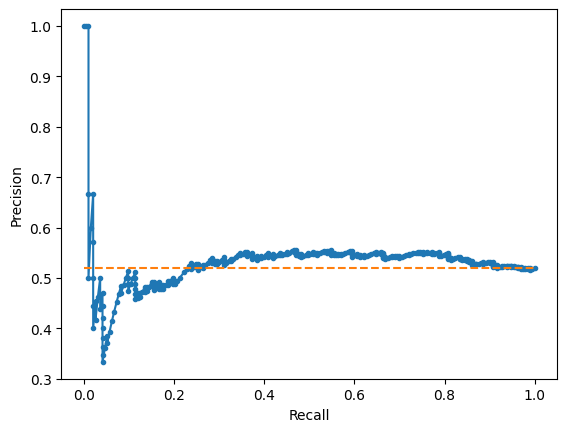

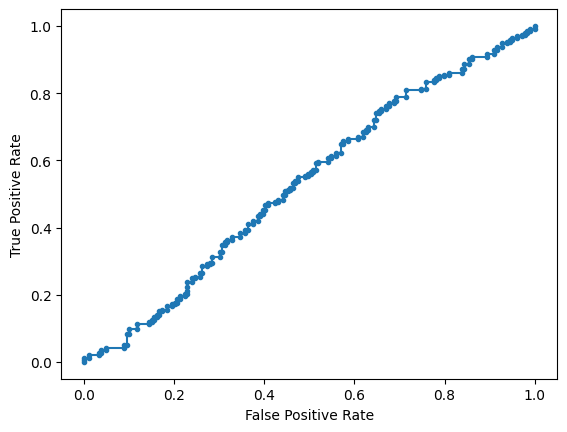

Accuracy: 52.69% Precision: 52.68% Recall: 86.53%
F1: 65.49% MCC: 0.0384
AUPRC: 53.01% AUROC: 53.12%
 accuracy [52.68817204301075]
 precision [52.6813880126183]
 recall [86.52849740932642]
 F1 [65.49019607843137]
 MCC [0.03842337831721155]
 AUPRC [53.0149671194951]
 AUROC [53.11893941586824]
2023-04-04 12:11:23.863622

Training # 1 3
2023-04-04 12:11:23.865222
2023-04-04 12:11:23.865300
Discriminator ZERO -1
Train 1:0 750:670 52.82%
Computed class weights: {0: 1.0597014925373134, 1: 0.9466666666666667}
Valid 1:0 185:148 55.56%
FIT
2023-04-04 12:11:23.917228


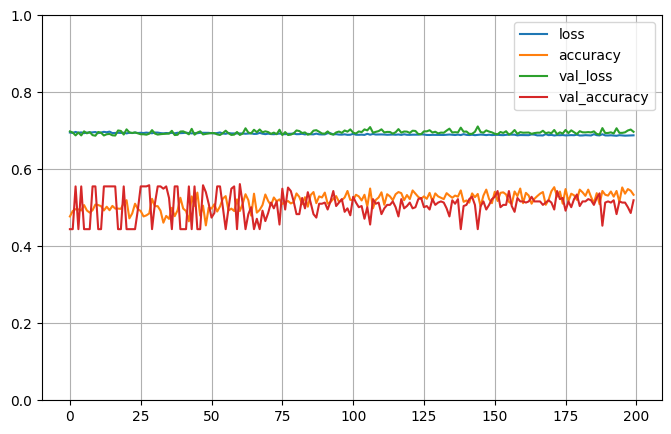


2023-04-04 12:11:57.313136

Testing # 1 3
2023-04-04 12:11:57.313428
2023-04-04 12:11:57.313467
PREDICT
2023-04-04 12:11:57.320488
Test 1:0 185:148 55.56%
Predict 1:0 221:112 66.37%
Test sizes (333, 1025) (333,)
Range of scores: 0.29210016 to 0.53394127
Score threshold 0.5
Confusion matrix
 [[ 50  98]
 [ 62 123]]
Normalized matrix
 [[0.15015015 0.29429429]
 [0.18618619 0.36936937]]


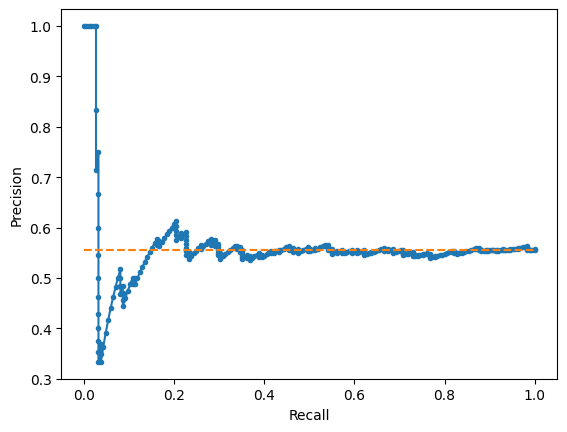

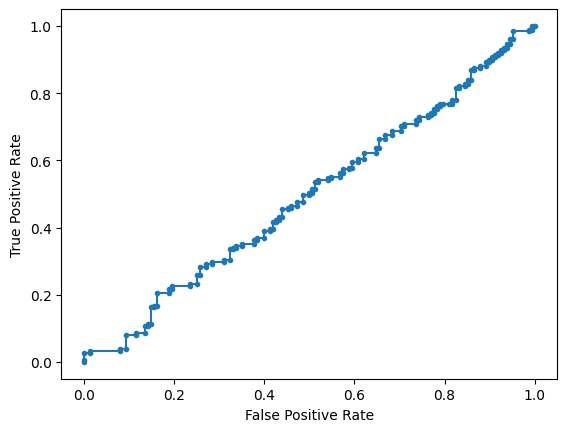

Accuracy: 51.95% Precision: 55.66% Recall: 66.49%
F1: 60.59% MCC: 0.0028
AUPRC: 55.88% AUROC: 49.36%
 accuracy [51.95195195195195]
 precision [55.65610859728507]
 recall [66.48648648648648]
 F1 [60.5911330049261]
 MCC [0.002842561369430512]
 AUPRC [55.876328223597625]
 AUROC [49.3608473338203]
2023-04-04 12:11:58.331353

Training # 1 4
2023-04-04 12:11:58.332776
2023-04-04 12:11:58.333021
Discriminator ZERO -1
Train 1:0 744:639 53.80%
Computed class weights: {0: 1.0821596244131455, 1: 0.9294354838709677}
Valid 1:0 191:179 51.62%
FIT
2023-04-04 12:11:58.385816


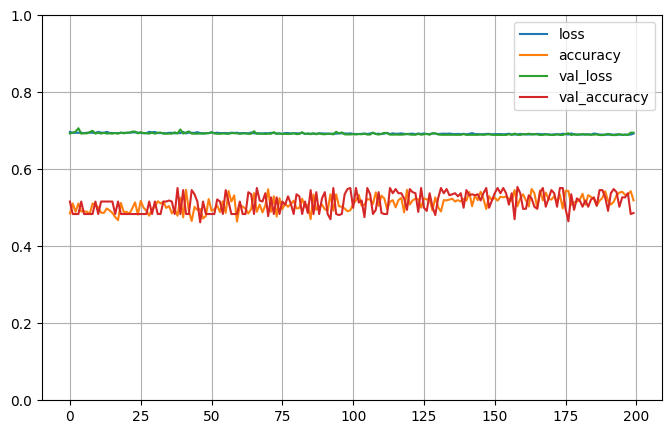


2023-04-04 12:12:30.333698

Testing # 1 4
2023-04-04 12:12:30.333995
2023-04-04 12:12:30.334039
PREDICT
2023-04-04 12:12:30.342303
Test 1:0 191:179 51.62%
Predict 1:0 3:367  0.81%
Test sizes (370, 1025) (370,)
Range of scores: 0.29646787 to 0.50117564
Score threshold 0.5
Confusion matrix
 [[178   1]
 [189   2]]
Normalized matrix
 [[0.48108108 0.0027027 ]
 [0.51081081 0.00540541]]


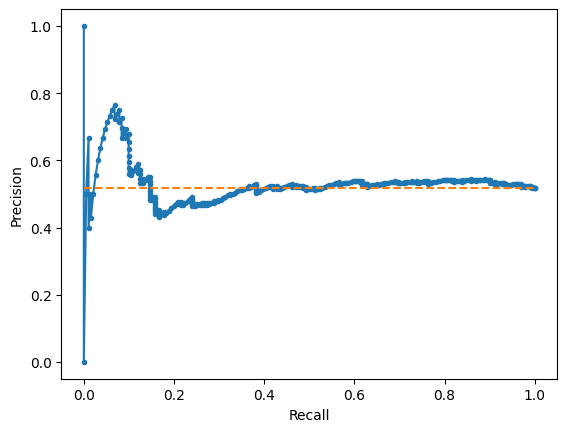

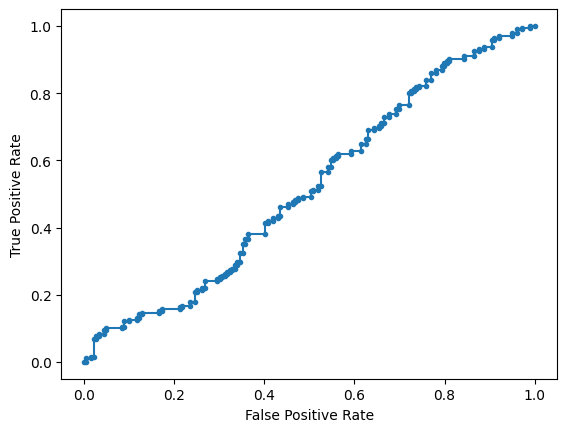

Accuracy: 48.65% Precision: 66.67% Recall: 1.05%
F1: 2.06% MCC: 0.0272
AUPRC: 52.93% AUROC: 51.91%
 accuracy [48.64864864864865]
 precision [66.66666666666666]
 recall [1.0471204188481675]
 F1 [2.0618556701030926]
 MCC [0.027219466734679745]
 AUPRC [52.93077535540267]
 AUROC [51.91435841937465]
2023-04-04 12:12:31.322806

Training # 1 5
2023-04-04 12:12:31.323803
2023-04-04 12:12:31.323851
Discriminator ZERO -1
Train 1:0 747:656 53.24%
Computed class weights: {0: 1.069359756097561, 1: 0.9390896921017403}
Valid 1:0 188:162 53.71%
FIT
2023-04-04 12:12:31.379011


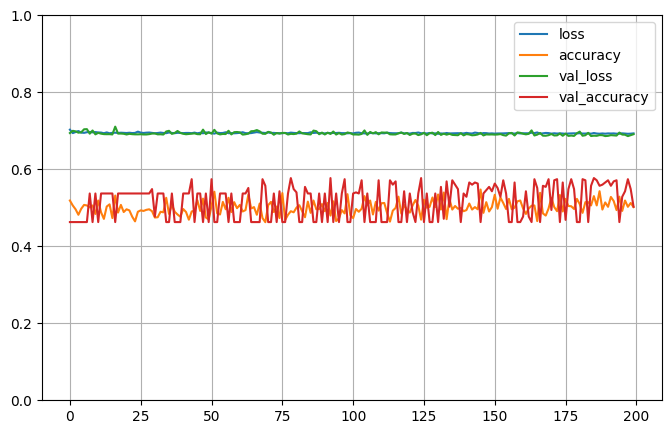


2023-04-04 12:13:02.239669

Testing # 1 5
2023-04-04 12:13:02.241360
2023-04-04 12:13:02.241393
PREDICT
2023-04-04 12:13:02.243867
Test 1:0 188:162 53.71%
Predict 1:0 112:238 32.00%
Test sizes (350, 1025) (350,)
Range of scores: 0.43302464 to 0.5079764
Score threshold 0.5
Confusion matrix
 [[113  49]
 [125  63]]
Normalized matrix
 [[0.32285714 0.14      ]
 [0.35714286 0.18      ]]


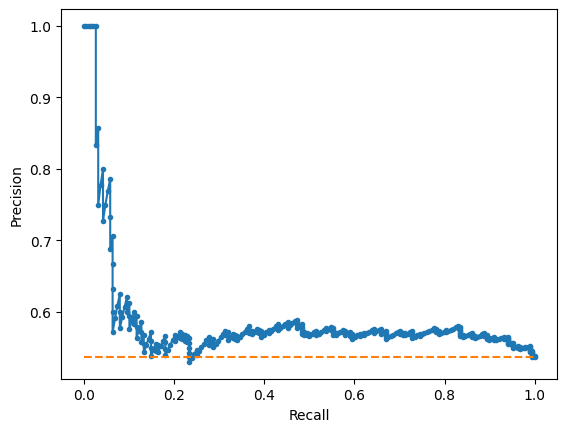

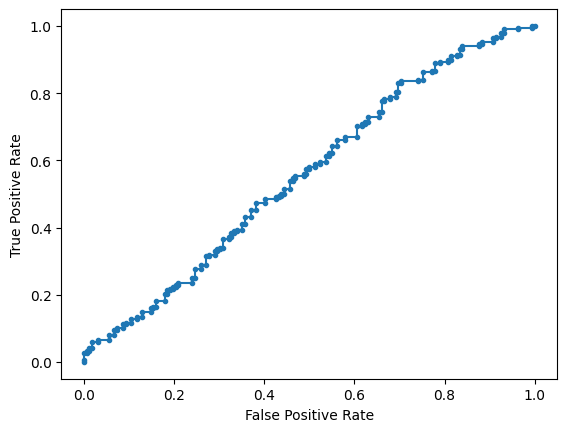

Accuracy: 50.29% Precision: 56.25% Recall: 33.51%
F1: 42.00% MCC: 0.0349
AUPRC: 58.71% AUROC: 55.81%
 accuracy [50.28571428571429]
 precision [56.25]
 recall [33.51063829787234]
 F1 [42.00000000000001]
 MCC [0.03488610331602984]
 AUPRC [58.70543775483019]
 AUROC [55.80509587601787]
2023-04-04 12:13:03.216447

Training # 2 1
2023-04-04 12:13:03.218521
2023-04-04 12:13:03.218965
Discriminator ZERO -1
Train 1:0 737:661 52.72%
Computed class weights: {0: 1.0574886535552193, 1: 0.9484396200814111}
Valid 1:0 198:157 55.77%
FIT
2023-04-04 12:13:03.287337


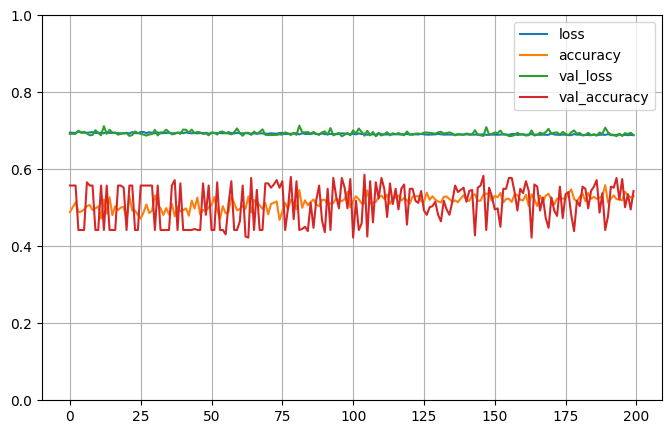


2023-04-04 12:13:45.477079

Testing # 2 1
2023-04-04 12:13:45.477176
2023-04-04 12:13:45.477211
PREDICT
2023-04-04 12:13:45.482414
Test 1:0 198:157 55.77%
Predict 1:0 270:85 76.06%
Test sizes (355, 1025) (355,)
Range of scores: 0.2973212 to 0.5496019
Score threshold 0.5
Confusion matrix
 [[ 40 117]
 [ 45 153]]
Normalized matrix
 [[0.11267606 0.32957746]
 [0.12676056 0.43098592]]


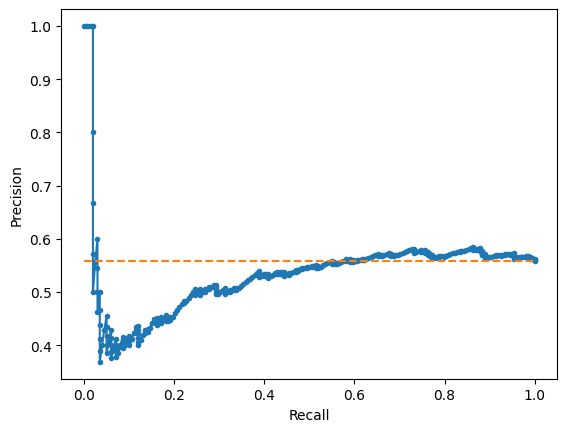

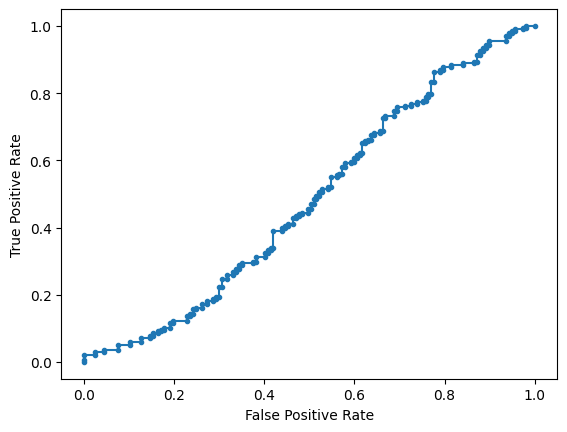

Accuracy: 54.37% Precision: 56.67% Recall: 77.27%
F1: 65.38% MCC: 0.0320
AUPRC: 53.57% AUROC: 48.43%
 accuracy [54.3661971830986]
 precision [56.666666666666664]
 recall [77.27272727272727]
 F1 [65.38461538461539]
 MCC [0.03201049193894527]
 AUPRC [53.57363161234969]
 AUROC [48.4333783696841]
2023-04-04 12:13:46.414787

Training # 2 2
2023-04-04 12:13:46.414978
2023-04-04 12:13:46.415029
Discriminator ZERO -1
Train 1:0 744:665 52.80%
Computed class weights: {0: 1.0593984962406016, 1: 0.9469086021505376}
Valid 1:0 191:153 55.52%
FIT
2023-04-04 12:13:46.475299


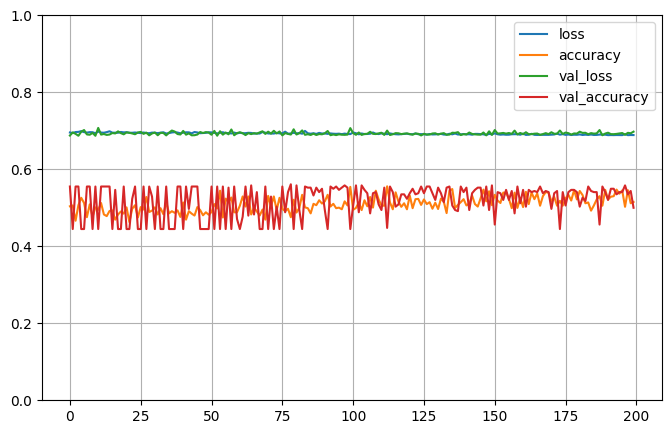


2023-04-04 12:14:17.805739

Testing # 2 2
2023-04-04 12:14:17.806001
2023-04-04 12:14:17.806047
PREDICT
2023-04-04 12:14:17.813129
Test 1:0 191:153 55.52%
Predict 1:0 179:165 52.03%
Test sizes (344, 1025) (344,)
Range of scores: 0.28388226 to 0.5175315
Score threshold 0.5
Confusion matrix
 [[73 80]
 [92 99]]
Normalized matrix
 [[0.2122093  0.23255814]
 [0.26744186 0.2877907 ]]


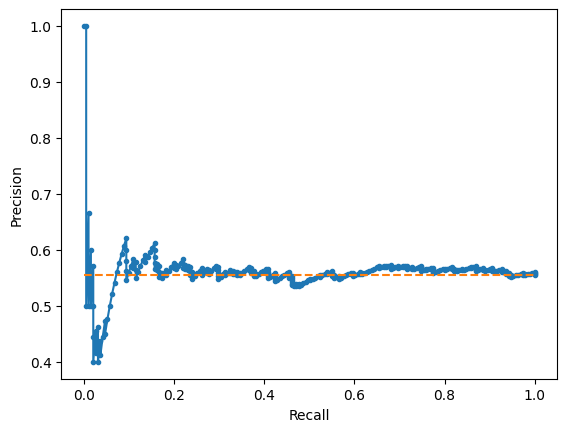

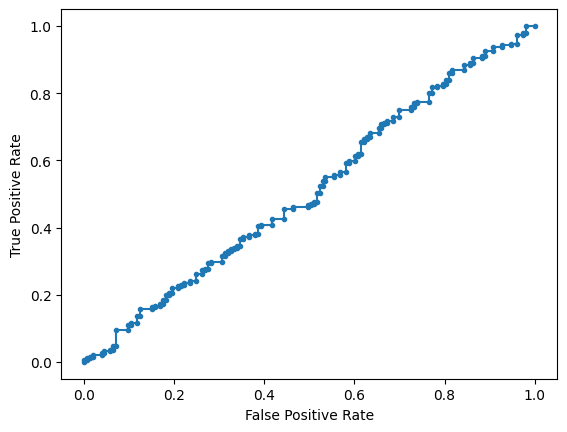

Accuracy: 50.00% Precision: 55.31% Recall: 51.83%
F1: 53.51% MCC: -0.0045
AUPRC: 55.98% AUROC: 51.11%
 accuracy [50.0]
 precision [55.3072625698324]
 recall [51.832460732984295]
 F1 [53.51351351351351]
 MCC [-0.0045271069478349975]
 AUPRC [55.984544546298174]
 AUROC [51.113848680833584]
2023-04-04 12:14:18.750514

Training # 2 3
2023-04-04 12:14:18.752338
2023-04-04 12:14:18.752733
Discriminator ZERO -1
Train 1:0 758:653 53.72%
Computed class weights: {0: 1.0803981623277181, 1: 0.9307387862796834}
Valid 1:0 177:165 51.75%
FIT
2023-04-04 12:14:18.816198


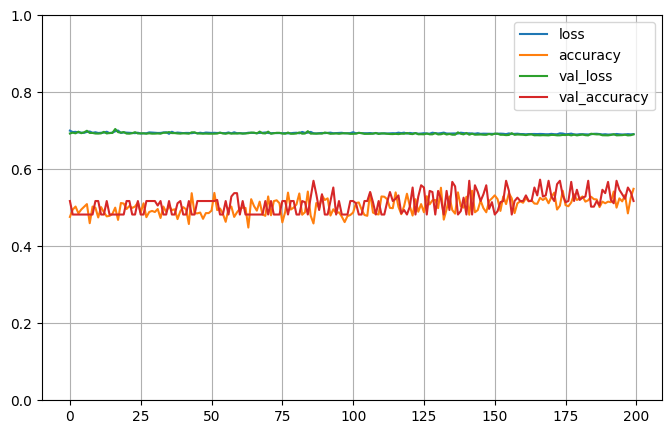


2023-04-04 12:14:51.403138

Testing # 2 3
2023-04-04 12:14:51.403543
2023-04-04 12:14:51.403571
PREDICT
2023-04-04 12:14:51.406690
Test 1:0 177:165 51.75%
Predict 1:0 148:194 43.27%
Test sizes (342, 1025) (342,)
Range of scores: 0.31804562 to 0.5125895
Score threshold 0.5
Confusion matrix
 [[97 68]
 [97 80]]
Normalized matrix
 [[0.28362573 0.19883041]
 [0.28362573 0.23391813]]


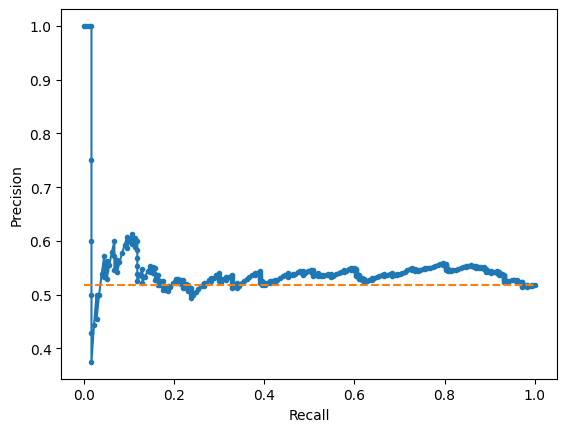

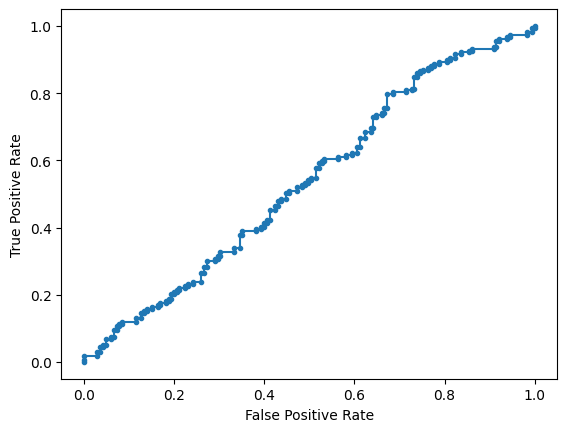

Accuracy: 51.75% Precision: 54.05% Recall: 45.20%
F1: 49.23% MCC: 0.0402
AUPRC: 54.43% AUROC: 53.82%
 accuracy [51.75438596491229]
 precision [54.054054054054056]
 recall [45.19774011299435]
 F1 [49.230769230769226]
 MCC [0.04019690841718951]
 AUPRC [54.42740116186271]
 AUROC [53.8195514466701]
2023-04-04 12:14:52.341153

Training # 2 4
2023-04-04 12:14:52.342461
2023-04-04 12:14:52.342507
Discriminator ZERO -1
Train 1:0 758:640 54.22%
Computed class weights: {0: 1.0921875, 1: 0.9221635883905013}
Valid 1:0 177:178 49.86%
FIT
2023-04-04 12:14:52.398542


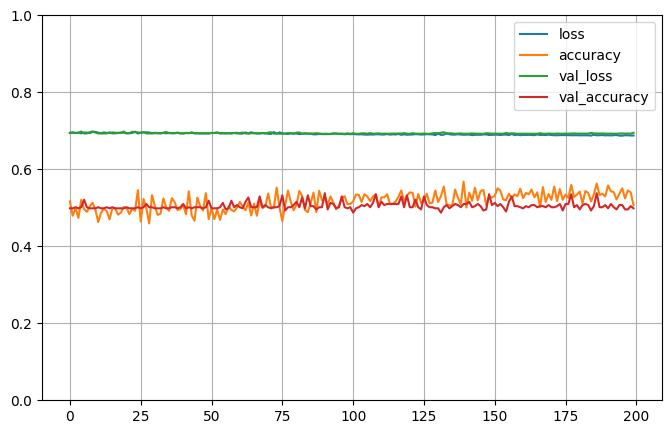


2023-04-04 12:15:25.104883

Testing # 2 4
2023-04-04 12:15:25.104956
2023-04-04 12:15:25.104984
PREDICT
2023-04-04 12:15:25.107368
Test 1:0 177:178 49.86%
Predict 1:0 307:48 86.48%
Test sizes (355, 1025) (355,)
Range of scores: 0.32094845 to 0.5673936
Score threshold 0.5
Confusion matrix
 [[ 24 154]
 [ 24 153]]
Normalized matrix
 [[0.06760563 0.43380282]
 [0.06760563 0.43098592]]


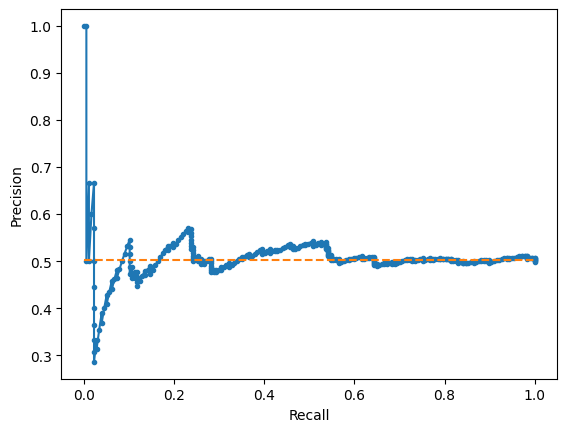

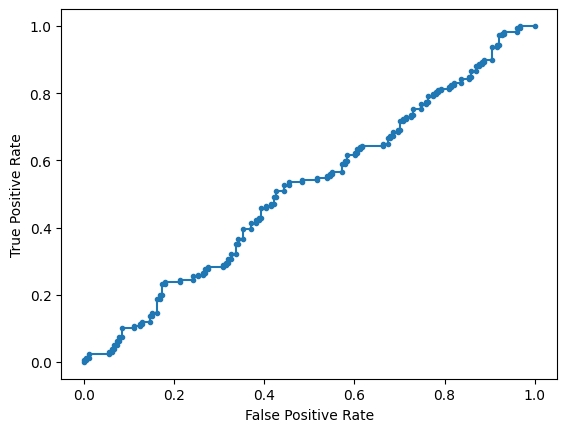

Accuracy: 49.86% Precision: 49.84% Recall: 86.44%
F1: 63.22% MCC: -0.0011
AUPRC: 50.64% AUROC: 51.48%
 accuracy [49.859154929577464]
 precision [49.8371335504886]
 recall [86.4406779661017]
 F1 [63.22314049586777]
 MCC [-0.001113845105888445]
 AUPRC [50.63891602481204]
 AUROC [51.47590935059989]
2023-04-04 12:15:26.033904

Training # 2 5
2023-04-04 12:15:26.034946
2023-04-04 12:15:26.035013
Discriminator ZERO -1
Train 1:0 743:653 53.22%
Computed class weights: {0: 1.0689127105666156, 1: 0.9394347240915208}
Valid 1:0 192:165 53.78%
FIT
2023-04-04 12:15:26.092366


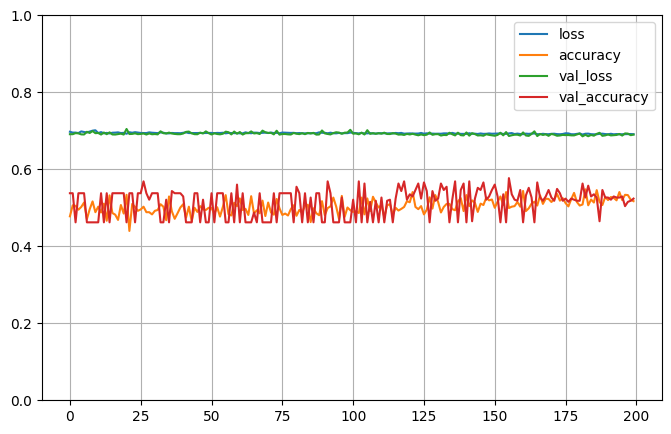


2023-04-04 12:16:08.057285

Testing # 2 5
2023-04-04 12:16:08.057558
2023-04-04 12:16:08.059779
PREDICT
2023-04-04 12:16:08.062831
Test 1:0 192:165 53.78%
Predict 1:0 174:183 48.74%
Test sizes (357, 1025) (357,)
Range of scores: 0.36360005 to 0.51877457
Score threshold 0.5
Confusion matrix
 [[89 76]
 [94 98]]
Normalized matrix
 [[0.24929972 0.21288515]
 [0.26330532 0.2745098 ]]


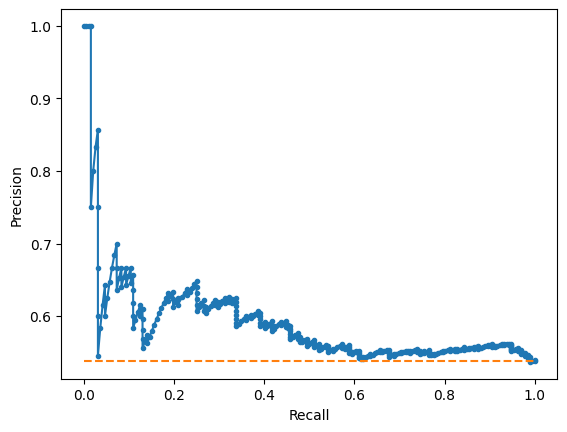

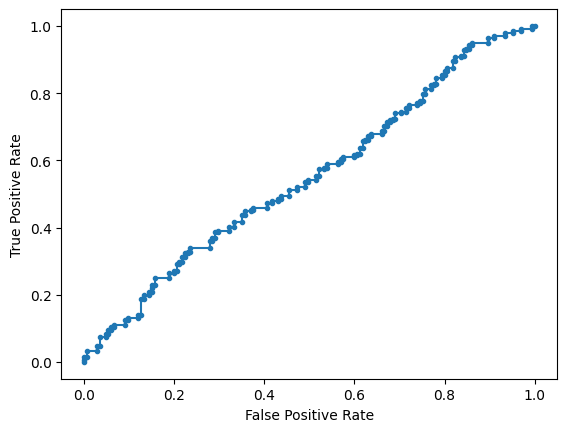

Accuracy: 52.38% Precision: 56.32% Recall: 51.04%
F1: 53.55% MCC: 0.0497
AUPRC: 58.99% AUROC: 54.97%
 accuracy [52.38095238095239]
 precision [56.32183908045977]
 recall [51.041666666666664]
 F1 [53.551912568306]
 MCC [0.04968373576697372]
 AUPRC [58.98644130900635]
 AUROC [54.97474747474749]
2023-04-04 12:16:08.509952


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 51.13% std 1.77
 precision mean 55.62% std 4.43
 recall mean 56.45% std 26.22
 F1 mean 51.33% std 18.86
 MCC mean 0.02% std 0.03
 AUPRC mean 54.90% std 2.60
 AUROC mean 51.94% std 2.48
 accuracy [[49.390243902439025], [52.68817204301075], [51.95195195195195], [48.64864864864865], [50.28571428571429], [54.3661971830986], [50.0], [51.75438596491229], [49.859154929577464], [52.38095238095239]]
 precision [[52.72727272727272], [52.6813880126183], [55.65610859728507], [66.66666666666666], [56.25], [56.666666666666664], [55.3072625698324], [54.054054054054056], [49.8371335504886], [56.32183908045977]]
 recall [[65.1685393258427], [86.52849740932642], [66.48648648648648], [1.0471204188481675], [33.51063829787234], [77.27272727272727], [51.832460732984295], [45.19774011299435], [86.4406779661017], [51.041666666666664]]
 F1 [[58.291457286432156], [65.49019607843137], [60.5911330049261], [2.0618556701030926], [42.00000000000001], [65.38461538461539], [53.51351351351351], [49.23076